In [1]:
# Load the packages
import pandas as pd
import numpy as np
from datetime import datetime
import tensorflow as tf
import sys
import csv
import math
import keras
import argparse
import scipy.io
import sklearn
import sklearn.datasets
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/home/affine/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras.regularizers import L1L2
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.optimizers import SGD

In [3]:
#Load dataset
master_data= pd.read_csv('/home/affine/Downloads/Deep_Learning/demo/demo/TGS/tgs-data-science-master-c3f8b3a2900f40ddde655f8ef5f17d00cfaa7033/data/Master_dataset_v1.csv')

/home/affine/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7,20,23,25,34,48,65,83) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#Columns in dataset
master_data.columns

Index(['Unnamed: 0', 'WellId', 'LeaseId', 'GroupId', 'API', 'FieldName_x',
       'Well Name and Number', 'WellNumber_x', 'OperatorName_x', 'StateName_x',
       'County_x', 'ProductionMonthYear', 'DaysOnProduction', 'Gas', 'Oil',
       'Water', 'ProductionType', 'ProductionTypeName', 'WellsReported',
       'AllocationMethod', 'DisplayFormation_x', 'StateLeaseId', 'WellName',
       'WellNumber_y', 'BasinName', 'DisplayFormation_y', 'Township',
       'TownshipDirection', 'Range', 'RangeDirection', 'Section', 'District',
       'Abstract', 'Survey', 'Block', 'Offshore', 'Area', 'OffshoreBlock',
       'QuarterQuarter', 'FootageNS', 'DirectionNS', 'FootageEW',
       'DirectionEW', 'SurfaceLatitude', 'SurfaceLongitude', 'BottomLatitude',
       'BottomLongitude', 'SpudDate', 'PlugDate', 'CompletionDate',
       'FirstProductionDate', 'FirstMonth', 'HasProduction', 'WellType',
       'TotalVerticalDepth', 'MeasuredDepth', 'ElevationGround',
       'ElevationKellyBushing', 'ElevationWat

In [25]:
#selecting Operator 'Occidental W TX OVERTHRUST INC.'
master_data1=master_data[master_data.OperatorName_x=="OCCIDENTAL W TX OVERTHRUST INC."]
#master_data1.head()

In [26]:
#select required API
master_data1=master_data1[master_data1.API==42371381280000]#42371381180000]#42371383480000]#42371381890000]#42371378930000]
labels=['Gas','ProductionMonthYear1','YearMonth']
master_data1=master_data1[labels]

#Sort data based on YearMonth
master_data1=master_data1.sort_values(by=['YearMonth'])#, ascending=[1, 1],axis=1)
#master_data1.tail()

In [27]:
master_data2=master_data1
master_data2=pd.DataFrame(master_data2)
# master_data2['start_date']=datetime.strptime(master_data1['ProductionMonthYear1'].iloc[0], "%Y-%m-%d")
# print(type(pd.DataFrame(master_data2['start_date']).iloc[0,0]))
# print(type(pd.DataFrame(master_data2['ProductionMonthYear1']).iloc[0,0]))

In [28]:
# master_data2['ProductionMonthYear1']=master_data2['ProductionMonthYear1'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))
# master_data2['days_age']=master_data2['ProductionMonthYear1'].sub(master_data2['start_date'])
# master_data2['days_age']=master_data2['days_age']/np.timedelta64(1,'D')

In [29]:
#Set YearMonth as Index for production
master_data2=master_data2[['YearMonth','Gas']]#,'days_age']]
master_data2=master_data2.iloc[:-1,:]# removing 201708 & 201709 values as they were zeros
master_data2.set_index('YearMonth')

,Gas
YearMonth,
200806,51495.0
200807,69471.0
200808,69494.0
200809,62770.0
200810,27003.0
200811,61651.0
200812,100072.0
200901,126303.0
200902,72185.0


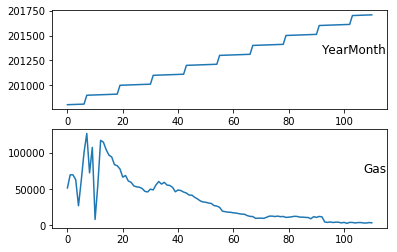

In [30]:
from matplotlib import pyplot
# load dataset
dataset = master_data2
values = dataset.values

# specify columns to plot
groups = [0,1]#,2]#3,4]#,5,6,7,8,9,10]
i = 0
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i+1)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [31]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [32]:
#Define lag(time steps for training) and n_seq(number of time steps to be predicted in future)
n_seq = 4
n_feature=1
n_lag= 6


In [33]:
# load dataset
dataset = master_data2.iloc[:,1:]
values = dataset.values
print(values.shape)
# ensure all data is float
values = values.astype('float32')
#print(values)

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled.shape)
# frame as supervised learning
reframed = series_to_supervised(scaled, n_lag, n_seq)

# drop columns we don't want to predict
# reframed.drop(reframed.iloc[:,25:], axis=1, inplace=True)
print(reframed.head())
print(reframed.shape)

(111, 1)
(111, 1)
    var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  \
6    0.393737   0.539419   0.539606   0.485113   0.195248   0.476044   
7    0.539419   0.539606   0.485113   0.195248   0.476044   0.787417   
8    0.539606   0.485113   0.195248   0.476044   0.787417   1.000000   
9    0.485113   0.195248   0.476044   0.787417   1.000000   0.561414   
10   0.195248   0.476044   0.787417   1.000000   0.561414   0.844820   

     var1(t)  var1(t+1)  var1(t+2)  var1(t+3)  
6   0.787417   1.000000   0.561414   0.844820  
7   1.000000   0.561414   0.844820   0.043042  
8   0.561414   0.844820   0.043042   0.431705  
9   0.844820   0.043042   0.431705   0.923237  
10  0.043042   0.431705   0.923237   0.902709  
(102, 10)


In [34]:
# split into train and test sets
values = reframed.values
train = values[:-1, :]
test = values[-1:, :]

# split into input and outputs
train_X, train_y = train[:, :-(n_seq)], train[:, -(n_seq):]
test_X, test_y = test[:, :-n_seq], test[:, -n_seq:]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_feature))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_feature))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(101, 6, 1) (101, 4) (1, 6, 1) (1, 4)


In [101]:
#Hyperparameters
h1=n_lag*2
h2=n_lag*2
h3=n_seq
h4=n_seq
drop1=0.3
drop2=0.2
drop3=0.1 
drop4=0.1
n_y=n_seq
epoch=500
batch_size=16
lr=0.0008
L1=0.00
L2=0.01

In [90]:
# model.add(LSTM(h1, batch_input_shape=(batch_size,train_X.shape[1],train_X.shape[2]), stateful=True))#,return_sequences=True, recurrent_regularizer=reg))

In [91]:
# design network
model = Sequential()
reg = L1L2(l1=L1, l2=L2)
model.add(LSTM(h1, input_shape=(train_X.shape[1],train_X.shape[2]),return_sequences=True, recurrent_regularizer=reg))
model.add(Dropout(drop1, seed = 1))
model.add(LSTM(h2,return_sequences=True))
model.add(Dropout(drop2, seed = 1))
model.add(LSTM(h3,return_sequences=True))
model.add(Dropout(drop3, seed = 1))
model.add(LSTM(h4,return_sequences=False))
model.add(Dropout(drop4, seed = 1))
model.add(Dense(n_seq, activation='relu'))
model.add(Dense(n_y, activation='relu'))
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mae', optimizer= adam)

In [92]:
# model=load_model('LSTM_12_month.h5')
# weights=model.get_weights()
# print(weights)
# model.save_weights('weights.hdf5')
# model.set_weights(weights)
# model.load_weights('weights.hdf5')
# model.load_weights('weights_42371382790000.hdf5')

Train on 101 samples, validate on 1 samples
Epoch 1/500
 - 2s - loss: 0.3578 - val_loss: 0.1168
Epoch 2/500
 - 0s - loss: 0.3482 - val_loss: 0.1138
Epoch 3/500
 - 0s - loss: 0.3381 - val_loss: 0.1146
Epoch 4/500
 - 0s - loss: 0.3276 - val_loss: 0.1150
Epoch 5/500
 - 0s - loss: 0.3186 - val_loss: 0.1156
Epoch 6/500
 - 0s - loss: 0.3093 - val_loss: 0.1166
Epoch 7/500
 - 0s - loss: 0.3005 - val_loss: 0.1176
Epoch 8/500
 - 0s - loss: 0.2925 - val_loss: 0.1181
Epoch 9/500
 - 0s - loss: 0.2860 - val_loss: 0.1183
Epoch 10/500
 - 0s - loss: 0.2799 - val_loss: 0.1181
Epoch 11/500
 - 0s - loss: 0.2741 - val_loss: 0.1171
Epoch 12/500
 - 0s - loss: 0.2682 - val_loss: 0.1157
Epoch 13/500
 - 0s - loss: 0.2642 - val_loss: 0.1145
Epoch 14/500
 - 0s - loss: 0.2605 - val_loss: 0.1134
Epoch 15/500
 - 0s - loss: 0.2557 - val_loss: 0.1122
Epoch 16/500
 - 0s - loss: 0.2527 - val_loss: 0.1110
Epoch 17/500
 - 0s - loss: 0.2503 - val_loss: 0.1097
Epoch 18/500
 - 0s - loss: 0.2467 - val_loss: 0.1083
Epoch 19/50

Epoch 154/500
 - 0s - loss: 0.1097 - val_loss: 0.0144
Epoch 155/500
 - 0s - loss: 0.1153 - val_loss: 0.0126
Epoch 156/500
 - 0s - loss: 0.1199 - val_loss: 0.0117
Epoch 157/500
 - 0s - loss: 0.1131 - val_loss: 0.0122
Epoch 158/500
 - 0s - loss: 0.1119 - val_loss: 0.0135
Epoch 159/500
 - 0s - loss: 0.1125 - val_loss: 0.0146
Epoch 160/500
 - 0s - loss: 0.1179 - val_loss: 0.0142
Epoch 161/500
 - 0s - loss: 0.1177 - val_loss: 0.0132
Epoch 162/500
 - 0s - loss: 0.1177 - val_loss: 0.0138
Epoch 163/500
 - 0s - loss: 0.1140 - val_loss: 0.0121
Epoch 164/500
 - 0s - loss: 0.1156 - val_loss: 0.0113
Epoch 165/500
 - 0s - loss: 0.1177 - val_loss: 0.0126
Epoch 166/500
 - 0s - loss: 0.1159 - val_loss: 0.0144
Epoch 167/500
 - 0s - loss: 0.1162 - val_loss: 0.0136
Epoch 168/500
 - 0s - loss: 0.1208 - val_loss: 0.0117
Epoch 169/500
 - 0s - loss: 0.1148 - val_loss: 0.0114
Epoch 170/500
 - 0s - loss: 0.1209 - val_loss: 0.0127
Epoch 171/500
 - 0s - loss: 0.1182 - val_loss: 0.0138
Epoch 172/500
 - 0s - loss: 

Epoch 306/500
 - 0s - loss: 0.1147 - val_loss: 0.0096
Epoch 307/500
 - 0s - loss: 0.1140 - val_loss: 0.0087
Epoch 308/500
 - 0s - loss: 0.1123 - val_loss: 0.0071
Epoch 309/500
 - 0s - loss: 0.1139 - val_loss: 0.0074
Epoch 310/500
 - 0s - loss: 0.1125 - val_loss: 0.0084
Epoch 311/500
 - 0s - loss: 0.1167 - val_loss: 0.0097
Epoch 312/500
 - 0s - loss: 0.1094 - val_loss: 0.0100
Epoch 313/500
 - 0s - loss: 0.1149 - val_loss: 0.0096
Epoch 314/500
 - 0s - loss: 0.1131 - val_loss: 0.0092
Epoch 315/500
 - 0s - loss: 0.1158 - val_loss: 0.0067
Epoch 316/500
 - 0s - loss: 0.1130 - val_loss: 0.0047
Epoch 317/500
 - 0s - loss: 0.1111 - val_loss: 0.0056
Epoch 318/500
 - 0s - loss: 0.1172 - val_loss: 0.0098
Epoch 319/500
 - 0s - loss: 0.1153 - val_loss: 0.0121
Epoch 320/500
 - 0s - loss: 0.1124 - val_loss: 0.0114
Epoch 321/500
 - 0s - loss: 0.1104 - val_loss: 0.0099
Epoch 322/500
 - 0s - loss: 0.1113 - val_loss: 0.0094
Epoch 323/500
 - 0s - loss: 0.1175 - val_loss: 0.0096
Epoch 324/500
 - 0s - loss: 

Epoch 458/500
 - 0s - loss: 0.1141 - val_loss: 0.0070
Epoch 459/500
 - 0s - loss: 0.1122 - val_loss: 0.0096
Epoch 460/500
 - 0s - loss: 0.1089 - val_loss: 0.0100
Epoch 461/500
 - 0s - loss: 0.1121 - val_loss: 0.0081
Epoch 462/500
 - 0s - loss: 0.1130 - val_loss: 0.0071
Epoch 463/500
 - 0s - loss: 0.1094 - val_loss: 0.0082
Epoch 464/500
 - 0s - loss: 0.1101 - val_loss: 0.0087
Epoch 465/500
 - 0s - loss: 0.1125 - val_loss: 0.0084
Epoch 466/500
 - 0s - loss: 0.1128 - val_loss: 0.0085
Epoch 467/500
 - 0s - loss: 0.1133 - val_loss: 0.0095
Epoch 468/500
 - 0s - loss: 0.1114 - val_loss: 0.0096
Epoch 469/500
 - 0s - loss: 0.1110 - val_loss: 0.0068
Epoch 470/500
 - 0s - loss: 0.1118 - val_loss: 0.0042
Epoch 471/500
 - 0s - loss: 0.1132 - val_loss: 0.0051
Epoch 472/500
 - 0s - loss: 0.1138 - val_loss: 0.0098
Epoch 473/500
 - 0s - loss: 0.1115 - val_loss: 0.0112
Epoch 474/500
 - 0s - loss: 0.1122 - val_loss: 0.0083
Epoch 475/500
 - 0s - loss: 0.1127 - val_loss: 0.0060
Epoch 476/500
 - 0s - loss: 

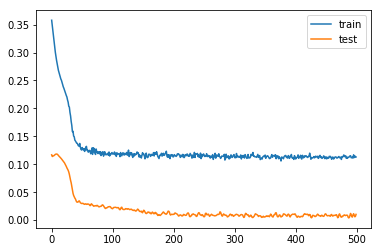

In [93]:
# fit network
history = model.fit(train_X, train_y, epochs = epoch, batch_size = batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# model.save('LSTM_12_month_42371381280000_v1.h5')
# del model

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [102]:
#SAVE THE MODEL

# model.save('LSTM_12_month_42371381280000_gas_v2.h5')
model=load_model('LSTM_12_month_42371381280000_gas_v1.h5')
# weights=model.get_weights()
# print(weights)
# model.save_weights('weights_42371381280000_gas_v2.hdf5')
# model.set_weights(weights)
weights=model.load_weights('weights_42371381280000_gas_v1.hdf5')
# model.set_weights(weights)

In [103]:
#Predict the model on test
yhat = model.predict(test_X)
# print(yhat.shape)
# print(test_y.shape)

# invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)
# print(inv_yhat.shape)
inv_yhat = inv_yhat[:,:]

# invert scaling for actual
inv_y = scaler.inverse_transform(test_y)
inv_y = inv_y[:,:]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

#def mean_absolute_error(y_true, y_pred):
MAE = mean_absolute_error(inv_y, inv_yhat)
print("MAE = "+str(MAE))

Test RMSE: 410.619
MAE = 373.975


In [104]:
# make a prediction on train
yhat_train = model.predict(train_X)

# invert scaling for train forecast
inv_yhat_train = scaler.inverse_transform(yhat_train)

# invert scaling for actual train
inv_y_train = scaler.inverse_transform(train_y)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_train, inv_yhat_train))
print('Train RMSE: %.3f' % rmse)

#def mean_absolute_error(y_true, y_pred):
MAE_train = mean_absolute_error(inv_y_train, inv_yhat_train)
print("MAE Train = "+str(MAE_train))

Train RMSE: 13993.655
MAE Train = 6914.84


In [105]:
# Calculate Mape
# Note LSTM always gives 1 step shifted reponse

#test Mape
Mape_test1=[]
for i in range(n_seq-1):
    mape1=(np.abs(inv_y[:,i]-inv_yhat[:,i+1])/(inv_y[:,i]+1))
    Mape_test1.append(mape1)
#print(Mape_test1)
Mape_test=np.mean(Mape_test1)

#Mape_test=np.mean(np.abs(inv_y[i]-inv_yhat[i+1])/(inv_y[i]+1))
#Mape_train=np.mean(np.abs(inv_y_train[i]-inv_yhat_train[i+1])/(inv_y_train[i]+1))
Mape_train=np.mean(np.abs(inv_y_train-inv_yhat_train)/(inv_y_train+1))

print("MAPE Train = "+str(Mape_train))
print("MAPE Test = "+str(Mape_test))

MAPE Train = 0.261437
MAPE Test = 0.103659


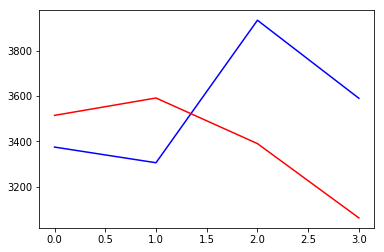

In [106]:
#red-predicted production
#blue-actual production
df1=pd.DataFrame(inv_y)
df2=pd.DataFrame(inv_yhat)
value1=df1.values
value2=df2.values
value1=value1.reshape(n_seq,1)
value2=value2.reshape(n_seq,1)
plt.figure()
plt.plot(value1,'b')
plt.plot(value2,'r')
plt.show()

In [107]:
# df1=pd.DataFrame(inv_y_train[0,:])
# df2=pd.DataFrame(inv_yhat_train[0,:])
# print(inv_y_train.shape)
# value1=df1.values
# value2=df2.values
# value1=value1.reshape(n_seq,1)
# value2=value2.reshape(n_seq,1)
# plt.figure()
# plt.plot(value1,'b')
# plt.plot(value2,'r')
# plt.show()

# df1=pd.DataFrame(inv_y_train[20,:])
# df2=pd.DataFrame(inv_yhat_train[20,:])
# print(inv_y_train.shape)
# value1=df1.values
# value2=df2.values
# value1=value1.reshape(n_seq,1)
# value2=value2.reshape(n_seq,1)
# plt.figure()
# plt.plot(value1,'b')
# plt.plot(value2,'r')
# plt.show()

# df1=pd.DataFrame(inv_y_train[40,:])
# df2=pd.DataFrame(inv_yhat_train[40,:])
# print(inv_y_train.shape)
# value1=df1.values
# value2=df2.values
# value1=value1.reshape(n_seq,1)
# value2=value2.reshape(n_seq,1)
# plt.figure()
# plt.plot(value1,'b')
# plt.plot(value2,'r')
# plt.show()

In [108]:
for i in range(len(inv_y)):
    for j in range(len(inv_y[i])):
        print(str(inv_y[i][j])+", "+str(inv_yhat[i][j]))

3375.0, 3514.7
3306.0, 3591.37
3934.0, 3390.33
3590.0, 3062.84


In [109]:
# get test results in CSV
df1=pd.DataFrame(inv_y[:,:-1])
df1=pd.DataFrame.transpose(df1)
df2=pd.DataFrame(inv_yhat[:,1:])
df2=pd.DataFrame.transpose(df2)
df3=pd.DataFrame(np.array(master_data2.iloc[-n_seq:-1,:]))
df3.columns=['YearMonth','Gas']
df4=pd.concat([df3,df1,df2],axis=1)
df4.columns=['YearMonth','Gas','Gas_Actual','Gas_Predicted']
print(df4)

   YearMonth     Gas  Gas_Actual  Gas_Predicted
0   201705.0  3375.0      3375.0    3591.367188
1   201706.0  3306.0      3306.0    3390.325928
2   201707.0  3934.0      3934.0    3062.837402


In [110]:
df4.to_csv('/home/affine/Downloads/Deep_Learning/demo/demo/TGS/Models/Outputs/Gas_API_42371381280000_prediction.csv')

In [111]:
df1=pd.DataFrame(inv_y_train)
df11=df1.iloc[:,0]

df2=pd.DataFrame(inv_yhat_train)
df12=df2.iloc[:,0]

df3=pd.DataFrame(np.array(master_data2.iloc[6:-n_seq,:]))
print(df3.shape)
df3.columns=['YearMonth','Gas']

df_train=pd.concat([df3,df11,df12], axis=1)
df_train1=pd.DataFrame(np.array(df_train))
df_train1.columns=['YearMonth','Gas','Gas_Actual','Gas_Predicted']
df_train1

(101, 2)


,YearMonth,Gas,Gas_Actual,Gas_Predicted
0,200812.0,100072.0,100072.000000,54181.972656
1,200901.0,126303.0,126303.000000,56220.234375
2,200902.0,72185.0,72185.000000,57536.179688
3,200903.0,107155.0,107155.000000,60955.812500
4,200904.0,8222.0,8222.000000,66377.851562
5,200905.0,56180.0,56180.000000,72612.484375
6,200906.0,116831.0,116831.000000,73850.101562
7,200907.0,114298.0,114298.000000,71341.312500
8,200908.0,104115.0,104115.000000,64196.152344
9,200909.0,96614.0,96614.000000,66468.742188


In [112]:
df_train1.to_csv('/home/affine/Downloads/Deep_Learning/demo/demo/TGS/Models/Outputs/Gas_API_42371381280000_train_prediction.csv')